<div class="alert alert-block alert-info">
<b>How to run this notebook?</b><br />
<ol>
    <li>Install the DockStream environment: conda env create -f environment.yml in the DockStream directory</li>
    <li>Activate the environment: conda activate DockStreamCommunity</li>
    <li>Execute jupyter: jupyter notebook</li>
    <li> Copy the link to a browser</li>
    <li> Update variables <b>dockstream_path</b> and <b>dockstream_env</b> (the path to the environment DockStream) in the 
        first code block below</li>
    </ol>
</div>

# `Glide` backend demo
This notebook will demonstrate how to **(a)** set up a `Glide` backend run with `DockStream`, including the most important settings and **(b)** how to set up a `REINVENT` run with `Glide` docking enabled as one of the scoring function components.

**Steps:**
* a: Set up `DockStream` run
  1. Prepare the receptor / grid with `Maestro`
  2. Prepare the input: SMILES and configuration file (JSON format)
  3. Execute the docking and parse the results
* b: Set up `REINVENT` run with a `DockStream` component
  1. Prepare the receptor (see *a.1*)
  2. Prepare the input (see *a.2*)
  3. Prepare the `REINVENT` configuration (JSON format)
  4. Execute `REINVENT`


If a `Schrodinger` license is available, `DockStream` can make use of `Glide`'s docking capabilities. However, you need to be able to source the _SCHRODINGER_ environment variable in your console. __Note:__ Make sure, you have activated the `DockStream` environment before launching this notebook. By default, this notebook will deposit all files created into `~/Desktop/Glide_demo`.

The following imports / loadings are only necessary when executing this notebook. If you want to use `DockStream` directly from the command-line, it is enough to execute the following with the appropriate configurations:

```
conda activate DockStream
python /path/to/DockStream/docker.py -conf docking.json
```

In [1]:
import os
import json
import tempfile
import seaborn as sns

# update these paths to reflect your system's configuration
dockstream_path = os.path.expanduser("~/Desktop/ProjectData/DockStream")
dockstream_env = os.path.expanduser("~/miniconda3/envs/DockStream")

# no changes are necessary beyond this point
# ---------
# get the notebook's root path
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

# generate the paths to the entry points
docker = dockstream_path + "/docker.py"

# generate a folder to store the results
output_dir = os.path.expanduser("~/Desktop/Glide_demo")
try:
    os.mkdir(output_dir)
except FileExistsError:
    pass

In [2]:
# generate the paths to the files shipped with this implementation
grid_file_path = ipynb_path + "/../data/Glide/1UYD_grid.zip"
smiles_path = ipynb_path + "/../data/1UYD/ligands_smiles.txt"

# generate output paths for the configuration file, embedded ligands, the docked ligands and the scores
docking_path = output_dir + "/Glide_docking.json"
ligands_conformers_path = output_dir + "/ligprep_embedded_ligands.sdf"
ligands_docked_path = output_dir + "/Glide_docked_ligands.sdf"
ligands_scores_path = output_dir + "/Glide_scores.csv"

## Target preparation
As of yet, `DockStream` does not have a specific target preparator for `Glide`. While this would be possible, feedback from users indicate that they are preferring to set the receptor up with `Maestro` (`Schrodinger`'s GUI), which results in a `zip` file containing all structural and force-field information. `Maestro` has extensive fixing capabilities and a wide variety of additional options. Below are a few screenshots from the "2019-4" release, showing how a target grid could be prepared. To reproduce them, download `1UYD` and load it into `Maestro`:

![](img/Glide_01_load_structure.png)

Next, load the protein preparation wizard and fix the most severe issues with your input structure.

![](img/Glide_02_protein_fix.png)

Once the protein structure is fixed, we need to generate the grid for docking. Start the grid generation assistant and select the reference ligand.

![](img/Glide_03_select_ligand.png)
![](img/Glide_03_grid_generation.png)

You might want to change some settings, e.g. increasing the space around the reference ligand to be considered. Note, that you should set the write-out folder by clicking on "Job settings".

![](img/Glide_03_grid_generation_write_out.png)

Finally, start the run (and be patient, this will take some time). You should see a "glide-grid_1.zip" in the output folder specified. One example archive is also shipped in this `DockStream` installation and will be used below.

<div class="alert alert-block alert-warning">
    <b>Warning:</b><br />
    If you plan to use your grid file with DockStream, <b>do not</b> specify any rotatable bonds in the receptor 
    (e.g. -OH groups). These are incompatible with Glide's output option "ligandlib_sd", as they (slightly) 
    change the receptor configuration.
</div>

## Docking
In this section we consider a case where we have just prepared the receptor and want to dock a bunch of ligands (molecules, compounds) into the binding cleft. Often, we only have the structure of the molecules in the form of `SMILES`, rather than a 3D structure so the first step will be to generate these conformers before proceeding ("embedding"). In `DockStream`, you can embed your ligands with a variety of programs including `Corina`, `RDKit`, `OMEGA`, and `LigPrep` and use them freely with any backend. Here, we will use `LigPrep` for the conformer embedding.

In [3]:
# load the smiles (just for illustrative purposes)
# here, 15 moleucles will be used
with open(smiles_path, 'r') as f:
    smiles = [smile.strip() for smile in f.readlines()]
print(smiles)

['C#CCCCn1c(Cc2cc(OC)c(OC)c(OC)c2Cl)nc2c(N)ncnc21', 'CCCCn1c(Cc2cc(OC)c(OC)c(OC)c2)nc2c(N)ncnc21', 'CCCCn1c(Cc2cc(OC)ccc2OC)nc2c(N)ncnc21', 'CCCCn1c(Cc2cccc(OC)c2)nc2c(N)ncnc21', 'C#CCCCn1c(Cc2cc(OC)c(OC)c(OC)c2Cl)nc2c(N)nc(F)nc21', 'CCCCn1c(Cc2ccc(OC)cc2)nc2c(N)ncnc21', 'CCCCn1c(Cc2ccc3c(c2)OCO3)nc2c(N)ncnc21', 'CCCCn1c(Cc2cc(OC)ccc2OC)nc2c(N)nc(F)nc21', 'CCCCn1c(Cc2ccc3c(c2)OCO3)nc2c(N)nc(F)nc21', 'C#CCCCn1c(Cc2cc(OC)ccc2OC)nc2c(N)nc(F)nc21', 'CC(C)NCCCn1c(Cc2cc3c(cc2I)OCO3)nc2c(N)nc(F)nc21', 'CC(C)NCCCn1c(Sc2cc3c(cc2Br)OCO3)nc2c(N)ncnc21', 'CC(C)NCCCn1c(Sc2cc3c(cc2I)OCO3)nc2c(N)ncnc21', 'COc1ccc(OC)c(Cc2nc3nc(F)nc(N)c3[nH]2)c1', 'Nc1nccn2c(NCc3ccccc3)c(Cc3cc4c(cc3Br)OCO4)nc12']


While the embedding and docking tasks in `DockStream` are both specified in the same configuration file, they are handled independently. This means it is perfectly fine to either load conformers (from an `SDF` file) directly or to use a call of `docker.py` merely to generate conformers without doing the docking afterwards.

`DockStream` uses the notion of (embedding) "pool"s, of which multiple can be specified and accessed via identifiers. Note, that while the way conformers are generated is highly backend specific, `DockStream` allows you to use the results interchangably. This allows to (a) re-use embedded molecules for multiple docking runs (e.g. different scoring functions), without the necessity to embed them more than once and (b) to combine embeddings and docking backends freely. Below is also a simple definition of a docking run, note that for `Glide` you might want to do a run from within `Maestro` first and then use the generated `.in` file to set the `glide_keywords` (minimally, you need to specify `PRECISION` and the path to the receptor grid file).

In [4]:
# specify the embedding and docking JSON file as a dictionary and write it out
ed_dict = {
  "docking": {
    "header": {                                   # general settings
      "environment": {
      }
    },
    "ligand_preparation": {                       # the ligand preparation part, defines how to build the pool
      "embedding_pools": [
        {
          "pool_id": "Ligprep_pool",
          "type": "Ligprep",
          "parameters": {
            "prefix_execution": "module load schrodinger/2019-4",
            "parallelization": {
                "number_cores": 2
            },
            "use_epik": {
              "target_pH": 7.0,
              "pH_tolerance": 2.0
            },
            "force_field": "OPLS3e"
          },
          "input": {
            "standardize_smiles": False,
            "input_path": smiles_path,
            "type": "smi"                                   # expected input is a text file with smiles
          },
          "output": {                                       # the conformers can be written to a file, but "output" is
                                                            # not required as the ligands are forwarded internally
            "conformer_path": ligands_conformers_path, 
            "format": "sdf"
          }
        }
      ]
    },
    "docking_runs": [
        {
          "backend": "Glide",
          "run_id": "Glide_run",
        "input_pools": ["Ligprep_pool"],
        "parameters": {
          "prefix_execution": "module load schrodinger/2019-4", # will be executed before a program call
          "parallelization": {                              # if present, the number of cores to be used
                                                            # can be specified
            "number_cores": 2
          },
          "glide_flags": {                                  # all all command-line flags for Glide here 
            "-HOST": "localhost"
          },
          "glide_keywords": {                               # add all keywords for the "input.in" file here
            "AMIDE_MODE": "trans",
            "EXPANDED_SAMPLING": "True",
            "GRIDFILE": grid_file_path,
            "NENHANCED_SAMPLING": "2",
            "POSE_OUTTYPE": "ligandlib_sd",
            "POSES_PER_LIG": "3",
            "POSTDOCK_NPOSE": "15",
            "POSTDOCKSTRAIN": "True",
            "PRECISION": "HTVS",
            "REWARD_INTRA_HBONDS": "True"
          }
        },
        "output": {
          "poses": { "poses_path": ligands_docked_path },
          "scores": { "scores_path": ligands_scores_path }
        }
      }]}}

with open(docking_path, 'w') as f:
    json.dump(ed_dict, f, indent=2)

### Tautomer enumeration / Protonation states
Another option available is to use different tautomers / protonation states for your ligands. Depending on the backend used, but especially for `Glide`, the exact protonation of the ligands matters a lot. `LigPrep`'s `Epik` can achieve an enumeration, producing all states reasonable at the specified pH. `DockStream`'s internal ligand numbering scheme works as follows: any ligand gets an increasing number (starting with 0), the `ligand number`. Separated by a ':', every enumeration gets another number, e.g. "1:2" would be the second ligand's third enumeration. After docking, a third number is added for the pose, e.g. "2:2:1" in the final SDF output file would indicate the third ligand's third enumeration, docking pose two.

### Adding constraints and features to the `Glide` run
`Glide` allows you to set a large number of settings (see the list at the very end of the notebook). Apart from settings on `EXAMPLE_SAMPLING` and `NENHANCED_SAMPLING` (value of 1 to 4), which have proven to be useful, you may also want to set constraints and features. Note, that all parameters have to be given as strings. Here is an example:

```
...
  "glide_keywords": {
    "AMIDE_MODE": "trans",
    "EXPANDED_SAMPLING": "True",
    "GRIDFILE": "<path_to_grid_zip>",
    "NENHANCED_SAMPLING": "2",
    "POSE_OUTTYPE": "ligandlib_sd",
    "POSES_PER_LIG": "3",
    "POSTDOCK_NPOSE": "15",
    "POSTDOCKSTRAIN": "True",
    "PRECISION": "HTVS",
    "REWARD_INTRA_HBONDS": "True"
  },
  "[CONSTRAINT_GROUP:1]": {
    "USE_CONS": "A:ALA:72:H(hbond):1,",
    "NREQUIRED_CONS": "ALL"
  },
  "[FEATURE:1]": {
    "PATTERN1": "[N]#C 1 include",
    "PATTERN2": "[n] 1 include",
    "PATTERN3": "N(=N=N) 1 include",
    "PATTERN4": "N(=N)=N 1 include"
  },
...
```

### Token guard
For the usage of `Glide`, tokens managed by a central licensing server will be consumed for the duration of the run. It might happen that you run out of tokens and the docking will fail for that reason. To ensure protection against that scenario, you can specify a "token guard", which will halt the submission of the actual docking subjobs until enough tokens are available. For this to take effect the specification below has to be added to the `parameters` block for the docking run. Note, that you have to specify the token pool you want to protect against (e.g. "GLIDE_HTVS_DOCKING" for HTVS runs and "GLIDE_SP_DOCKING" for SP runs). You may have any number of token protections activated at a given time. The number next to it specifies the minimum number of tokens for a given pool which need to be available to proceed. Note, that any process will consume 4 tokens, so if you e.g. specify to use parallelization with 8 cores, you will need to request access to at least 32 tokens. The availability will be checked every `wait_interval_seconds` for a maximum duration of `wait_limit_seconds` (note that a value of 0 for the latter means "unlimited").
```
...
  "token_guard": {
    "prefix_execution": "module load schrodinger/2019-4",
    "token_pools": {
      "GLIDE_HTVS_DOCKING": 32
    },
    "wait_interval_seconds": 30,
    "wait_limit_seconds": 1200
  },
...
```

### Executing `DockStream`
The following command executes `DockStream` using the the configuration file we generated earlier. Note, that you might want to use the `-debug` flag when calling `DockStream` to get more comprehesive logging output. Logging and error messages will be saved in a file called `dockstream_run.log` (you will have to delete it manually if you restart a job).

In [5]:
# execute this in a command-line environment after replacing the parameters
!{dockstream_env}/bin/python {docker} -conf {docking_path} -print_scores

-6.12214
-4.83051
-5.01639
-6.1192
-6.20097
-6.8325
-7.59449
-4.96581
-7.68445
NA
-8.47572
-8.99103
-6.66036
-6.42559
-8.39076


Note, that the scores are usually outputted to a `CSV` file specified by the `scores` block, but that since we have used parameter `-print_scores` they will also be printed to `stdout` (line-by-line). Also note, that ligands that could not be docked successfully will result in `NA` values (for all backends, but `Glide` is particularly prone to that).

These scores are associated with docking poses (see picture below for a couple of ligands overlaid in the binding pocket).

![](img/docked_ligands_overlay_holo.png)

In [6]:
# show glimpse into contents of output CSV
!head -n 10 {ligands_scores_path}

ligand_number,enumeration,conformer_number,name,score,smiles,lowest_conformer
0,0,0,0:0:0,-6.12214,[H]C#CC([H])([H])C([H])([H])C([H])([H])n1c(C([H])([H])c2c([H])c(OC([H])([H])[H])c(OC([H])([H])[H])c(OC([H])([H])[H])c2Cl)nc2c(N([H])[H])nc([H])nc21,True
1,0,0,1:0:0,-4.83051,[H]c1nc(N([H])[H])c2nc(C([H])([H])c3c([H])c(OC([H])([H])[H])c(OC([H])([H])[H])c(OC([H])([H])[H])c3[H])n(C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c2n1,True
1,0,1,1:0:1,-3.9485,[H]c1nc(N([H])[H])c2nc(C([H])([H])c3c([H])c(OC([H])([H])[H])c(OC([H])([H])[H])c(OC([H])([H])[H])c3[H])n(C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c2n1,False
1,0,2,1:0:2,-3.81299,[H]c1nc(N([H])[H])c2nc(C([H])([H])c3c([H])c(OC([H])([H])[H])c(OC([H])([H])[H])c(OC([H])([H])[H])c3[H])n(C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c2n1,False
2,0,0,2:0:0,-5.01639,[H]c1nc(N([H])[H])c2nc(C([H])([H])c3c([H])c(OC([H])([H])[H])c([H])c([H])c3OC([H])([H])[H])n(C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c2n1,True
3,0,0,3:0:0,-6.1192,[H]c1nc

## Using `DockStream` as a scoring component in `REINVENT`
The *de novo* design platform `REINVENT` holds a recently added `DockStream` scoring function component (also check out our collection of notebooks in the [ReinventCommunity](https://github.com/MolecularAI/ReinventCommunity) repository). This means, provided that all necessary input files and configurations are available, you may run `REINVENT` and incorporate docking scores into the score of the compounds generated. Together with `FastROCS`, this represents the first step to integrate physico-chemical 3D information.

While the docking scores are a very crude proxy for the actual binding affinity (at best), it does prove useful as a *geometric filter* (removing ligands that obviously do not fit the binding cavity). Furthermore, a severe limitation of knowledge-based predictions e.g. in activity models is the domain applicability. Docking, as a chemical space agnostic component, can enhance the ability of the agent for scaffold-hopping, i.e. to explore novel sub-areas in the chemical space.

### The `REINVENT` configuration JSON

While every docking backend has its own configuration (see section above), calling `DockStream`'s `docker.py` entry point ensures, that they all follow the same external API. Thus the component that needs to be added to `REINVENT`'s JSON configuration (to the `scoring_function`->`parameters` list) looks as follows (irrespective of the backend):

```
{
    "component_type": "dockstream",
    "name": "dockstream",
    "weight": 1,
    "specific_parameters": {
        "transformation": {
            "transformation_type": "reverse_sigmoid",
            "low": -20,
            "high": -5,
            "k": 0.2
         },
        "configuration_path": "<absolute_path_to_DockStream_configuration>/docking.json",
        "docker_script_path": "<absolute_path_to_DockStream_source>/docker.py",
        "environment_path": "<absolute_path_to_miniconda_installation>/envs/DockStream/bin/python"
    }
}
```

You will need to update `configuration_path`, `docker_script_path` and the link to the environment, `environment_path` to match your system's configuration. It might be, that the latter two are already set to meaningful defaults, but your `DockStream` configuration JSON file will be specific for each run. In the example above, we have set `debug` to `false`. Setting that flag to `true`, which will cause `DockStream` to write out a much more comprehensive logging output which is recommended for testing a setup initially.

#### How to find an appropriate transformation?
We use a *reverse sigmoid* score transformation to bring the numeric, continuous value that was outputted by `DockStream` and fed back to `REINVENT` into a 0 to 1 regime. The parameters `low`, `high` and `k` are critical: their exact value naturally depends on the backend used, but also on the scoring function (make sure, "more negative is better" - otherwise you are looking for a *sigmoid* transformation) and potentially also the project used. The values reported here can be used as rule-of-thumb for a `Glide` run. Below is a code snippet, that helps to find the appropriate parameters (excerpt of the `ReinventCommunity` notebook `Score_Transformations`).

In [7]:
# load the dependencies and classes used
%run code/score_transformation.py

# set plotting parameters
small = 12
med = 16
large = 22
params = {"axes.titlesize": large,
          "legend.fontsize": med,
          "figure.figsize": (16, 10),
          "axes.labelsize": med,
          "axes.titlesize": med,
          "xtick.labelsize": med,
          "ytick.labelsize": med,
          "figure.titlesize": large}
plt.rcParams.update(params)
plt.style.use("seaborn-whitegrid")
sns.set_style("white")
%matplotlib inline

# set up Enums and factory
tt_enum = TransformationTypeEnum()
csp_enum = ComponentSpecificParametersEnum()
factory = TransformationFactory()

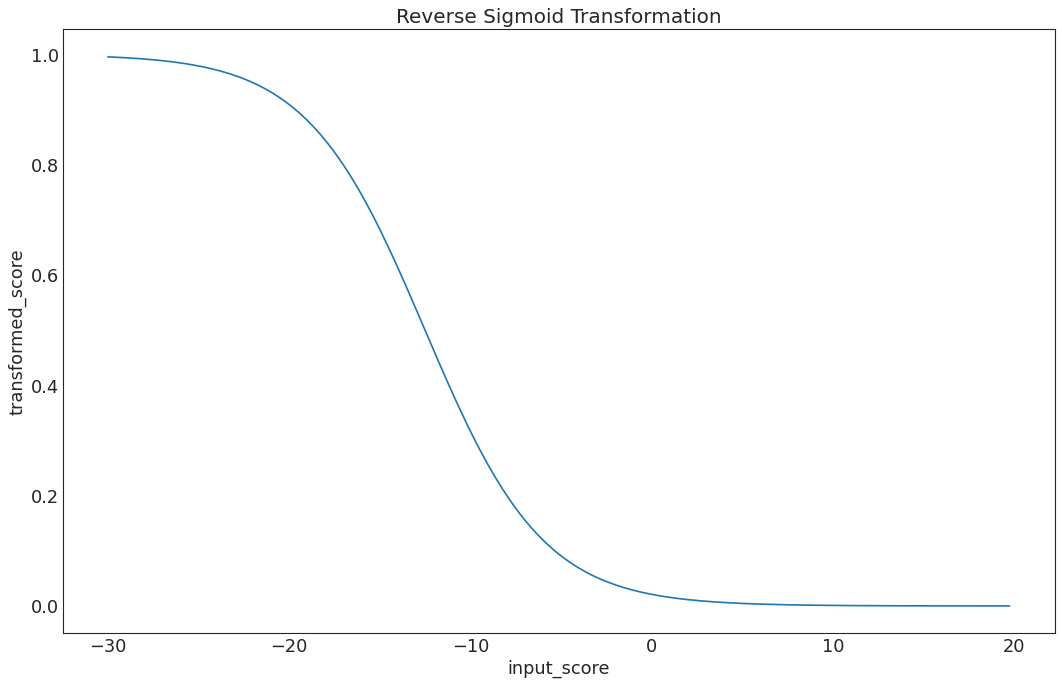

In [8]:
# reverse sigmoid transformation
# ---------
values_list = np.arange(-30, 20, 0.25).tolist()
specific_parameters = {csp_enum.TRANSFORMATION: True,
                       csp_enum.LOW: -20,
                       csp_enum.HIGH: -5,
                       csp_enum.K: 0.2,
                       csp_enum.TRANSFORMATION_TYPE: tt_enum.REVERSE_SIGMOID}
transform_function = factory.get_transformation_function(specific_parameters)
transformed_scores = transform_function(predictions=values_list,
                                        parameters=specific_parameters)

# render the curve
render_curve(title="Reverse Sigmoid Transformation", x=values_list, y=transformed_scores)

### How to specify the `DockStream` configuration file?
In principle, all options that are supported in a "normal" `DockStream` run (see above) are supported for usage with `REINVENT` as well, with a few notable exceptions. First, as we report only one value per ligand (and a "consensus score" is not yet supported), you should only use **one** embedding / pool and **one** backend (as in the example above). Second, the prospective ligands are not supplied via a file but from `stdin`, thus we will need to change the `input` part of the pool definition. Also, we might not want to write-out all conformers, so we will remove the `output` block entirely. The updated section then looks as follows:

```
{
    "pool_id": "Ligprep_pool",
    "type": "Ligprep",
    "parameters": {
        "prefix_execution": "module load schrodinger/2019-4",
        "parallelization": {
            "number_cores": 2
            },
            "use_epik": {
              "target_pH": 7.0,
              "pH_tolerance": 2.0
            },
            "force_field": "OPLS3e"
          },
     },
     "input": {
         "standardize_smiles": False,
         "type": console
     }
}
```

Finally, we will update the docking run as well. Typically, we want to see the docked poses per epoch and maybe also the scores and the SMILES in a well-tabulated format. Thus, we might retain the `output` block here, but as every epoch generates each of the files, it would overwrite it by default. If parameter `overwrite` is set to `False`, each consecutive write-out will be appended by a number, e.g. first epoch *poses.sdf* and *scores.csv*, second epoch *0001_poses.sdf* and *0001_scores.csv*, third epoch *0002_poses.sdf* and *0002_scores.csv* and so on.

```
{
  "backend": "Glide",
  "run_id": "Glide_run",
  "input_pools": ["Ligprep_pool"],
  "parameters": {
    "prefix_execution": "module load schrodinger/2019-4",
    "glide_flags": {
      "-NJOBS": 1,
      "-HOST": "localhost"
    },
    "glide_keywords": {
      "AMIDE_MODE": "trans",
      "EXPANDED_SAMPLING": "True",
      "GRIDFILE": "<absolute_path_to_grid_file>/grid.zip",
      "NENHANCED_SAMPLING": "2",
      "POSE_OUTTYPE": "ligandlib_sd",
      "POSES_PER_LIG": "3",
      "POSTDOCK_NPOSE": "15",
      "POSTDOCKSTRAIN": "True",
      "PRECISION": "HTVS",
      "REWARD_INTRA_HBONDS": "True"
    }
  },
  "output": {
    "poses": { "poses_path": "<absolute_path_to_poses_stem_file>/poses.sdf", "overwrite": False },
    "scores": { "scores_path": "<absolute_path_to_scores_stem_file>/scores.csv", "overwrite": False }
  }
}
```

### Block-keywords for `Glide` and list of keywords
In principle, there is no restriction on which keywords or flags you may use in connection with `Glide` (see the full list of keywords below). Note, however, that blocks (such as constraint definitions) have a slightly different syntax and

```
    "glide_keywords": {
      "PRECISION": "HTVS",
      "[CONSTRAINT_GROUP:1]": {
        "USE_CONS": "sulfonamide:1",
        "NREQUIRED_CONS": "ALL"
      },
      "[FEATURE:1]": {
        "PATTERN1": "[N-]S(=O)=O 1,2,3,4 include"
      }
    }
```

will result in

```
PRECISION: HTVS
[CONSTRAINT_GROUP:1]
    USE_CONS   sulfonamide:1,
    NREQUIRED_CONS   ALL
[FEATURE:1]
    PATTERN1   "[N-]S(=O)=O 1,2,3,4 include"
```

The following is a list of keywords for the `2019-4` realease of `Glide` and might be different for your version. Use `${SCHRODINGER}/glide -k` to see all of them.

```
AMIDE_MODE                  = option('penal', 'fixed', 'free', 'trans', 'generalized', default='generalized') # amide bond rotation behavior: "fixed", "free", "penal", "trans", "gen[eralized]"
AMIDE_TRANS_ALL             = boolean(default=False) # include "nonstandard" amides in trans enforcement
AMIDE_TRANSTOL              = float(default=20.0) # trans amide tolerance (in degrees)
ASL_RES_INTERACTION         = string(default=None) # If present, use it; else, use "radius_res_interaction."
ASLSTRINGS                  = string_list(default=list()) # ASL strings for receptor scaling
CALC_INPUT_RMS              = boolean(default=False) # report RMS deviation against input geometry of each ligand
CANONICALIZE                = boolean(default=True) # docking initiated from a canonical conformation per input ligand (false by default for HTVS precision)
COMPRESS_POSES              = boolean(default=True) # generate compressed maestro pose and _raw files
CORE_ATOMS                  = int_list(default=None) # index into reference ligand for each atom in core
CORE_DEFINITION             = option('all', 'allheavy', 'smarts', 'mcssmarts', 'atomlist', default='allheavy') # is core "all" atoms in molecule, "allheavy" (default), "smarts" pattern, "mcssmarts" (generate SMARTS from maximum common substructure), or "atomlist"
CORE_FILTER                 = boolean(default=False) # skip ligands that do not contain the core
CORE_POS_MAX_RMSD           = float(default=0.1) # maximum RMSD of core atom positions
CORE_RESTRAIN               = boolean(default=False) # restrain core atoms
CORE_RESTRAIN_V             = float(default=5.0) # strength of core restraining potential
CORE_SMARTS                 = string(default=None) # SMARTS pattern to match for core RMSD calculation/restraint
CORE_SNAP                   = boolean(default=None) # When using core constraints ("CORE_RESTRAIN yes"): if "yes", use "snapping" core constraints algorithm. If "no", use filtering algorithm. If not set, choose automatically based on CORE_POS_MAX_RMSD ("yes" if < 0.75; "no" otherwise)
CORECONS_FALLBACK           = boolean(default=False) # if a ligand fails to dock with CORE_SNAP retry it without
CSV_PROPS_FILE              = string(default='') # file containing names of m2io properties to be added to csvfile
CV_CUTOFF                   = float(default=0.0) # Coulomb-van der Waals energy cutoff used for final filtering
DIELMOD                     = option('rdiel', 'cdiel', default='rdiel') # type of dielectric to use: distance-dependent (rdiel) or constant (cdiel)
DOCKING_METHOD              = option('confgen', 'rigid', 'inplace', 'mininplace', default='confgen') # docking method: confgen=flexible docking; rigid=rigid docking; mininplace=refine (do not dock); inplace=score in place (do not dock)
DOINTRA                     = boolean(default=False) # relax bad intramolecular contacts
DOINTRA_SCALE               = float(default=1.0) # scaling factor for intramolecular pose relaxation
EPIK_PENALTIES              = boolean(default=True) # include ligand Epik state penalties in the Glide DockingScore scoring function
EXPANDED_SAMPLING           = boolean(default=False) # bypass elimination of poses in rough scoring stage (useful for fragment docking)
FITDEN                      = boolean(default=False) # activate docking with ligand density data from PrimeX
FLEXASL                     = string(default=None) # ASL defining flexible receptor atoms
FORCEFIELD                  = string(default='OPLS3') # force field
FORCEPLANAR                 = boolean(default=False) # trigger MMFFLD planarity options
GLIDE_CONFGEN_BADDIST2      = float(default=6.0, min=0.0) # distance cutoff, squared, for bad contacts in confgen
GLIDE_CONFGEN_EFCUT         = float(default=12.0, min=0.0) # energy cutoff during ligand conformer generation
GLIDE_CONS_FEAT_FILE        = string(default=None) # feature file name for constraints jobs
GLIDE_CONS_FINALONLY        = boolean(default=False) # only check for constraint satisfaction after docking is complete
GLIDE_CONS_RMETCOORD        = float_list(default=list()) # sphere radii of Glide metal_coordination constraints
GLIDE_CONS_RNOEMAX          = float_list(default=list()) # maximum distances for Glide NOE constraints
GLIDE_CONS_RNOEMIN          = float_list(default=list()) # minimum distances for Glide NOE constraints
GLIDE_CONS_RPOS             = float_list(default=list()) # sphere radii of Glide positional constraints
GLIDE_CONS_XMETCOORD        = float_list(default=list()) # X-coordinates of Glide metal-coordination constraints
GLIDE_CONS_XNOE             = float_list(default=list()) # X-coordinates of targets for Glide NOE constraints
GLIDE_CONS_XPOS             = float_list(default=list()) # X-coordinates of Glide positional constraints
GLIDE_CONS_YMETCOORD        = float_list(default=list()) # Y-coordinates of Glide metal-coordination constraints
GLIDE_CONS_YNOE             = float_list(default=list()) # Y-coordinates of targets for Glide NOE constraints
GLIDE_CONS_YPOS             = float_list(default=list()) # Y-coordinates of Glide positional constraints
GLIDE_CONS_ZMETCOORD        = float_list(default=list()) # Z-coordinates of Glide metal-coordination constraints
GLIDE_CONS_ZNOE             = float_list(default=list()) # Z-coordinates of targets for Glide NOE constraints
GLIDE_CONS_ZPOS             = float_list(default=list()) # Z-coordinates of Glide positional constraints
GLIDE_DIELCO                = float(default=2.0, min=0.0, max=9999.9) # dielectric constant
GLIDE_ELEMENTS              = boolean(default=False) # run in "Glide Elements" mode
GLIDE_EXVOL_PENAL_NUM       = float_list(default=list()) # maximum penalties in kcal/mol for each Glide excluded volume violation
GLIDE_EXVOL_PENAL_STRENGTH  = option('low', 'small', 'medium', 'high', 'large', default='large') # penalty specification for (all) Glide excluded volumes.
GLIDE_NTOTALCONS            = integer(default=0, min=0, max=10) # number of receptor atoms having constraints
GLIDE_NUMEXVOL              = integer(default=0, min=0) # number of receptor excluded-volume regions
GLIDE_NUMMETCOORDCONS       = integer(default=0, min=0) # number of receptor metal-coordination constraints
GLIDE_NUMMETCOORDSITES      = int_list(default=list()) # number of available coordination sites per metal-coordination constraint
GLIDE_NUMNOECONS            = integer(default=0, min=0) # number of receptor NOE constraints
GLIDE_NUMPOSITCONS          = integer(default=0, min=0) # number of receptor positional constraints
GLIDE_NUMUSEXVOL            = integer(default=0, min=0) # number of excluded-volume regions to use
GLIDE_OUTPUT_USEHTOR        = boolean(default=True) # use rotation of polar hydrogens as pose-distinguishing criterion
GLIDE_RECEP_ASLSCALE        = boolean(default=False) # for Glide gridgen jobs, take per-atom charge and radius scaling factors from ASL specification
GLIDE_RECEP_MAESCALE        = boolean(default=False) # for Glide gridgen jobs, take per-atom charge and radius scaling factors from properties written by Maestro to the receptor file
GLIDE_REFLIG_FORMAT         = option('maestro', 'sd', 'mol2', default='maestro') # Glide reference ligand file format
GLIDE_REXVOL                = float_list(default=list()) # sphere radii of Glide excluded volumes
GLIDE_REXVOLIN              = float_list(default=list()) # inner sphere (max penalty) radii of Glide excluded volumes
GLIDE_TORCONS_ALLBONDS      = bool_list(default=list()) # constrain all independent dihedrals (one per rotatable bond) contained in SMARTS pattern (if false, specified dihedrals only)
GLIDE_TORCONS_IATOMS        = int_list(default=list()) # first of four atoms (index into SMARTS pattern) forming dihedral to be constrained
GLIDE_TORCONS_JATOMS        = int_list(default=list()) # second of four atoms (index into SMARTS pattern) forming dihedral to be constrained
GLIDE_TORCONS_KATOMS        = int_list(default=list()) # third of four atoms (index into SMARTS pattern) forming dihedral to be constrained
GLIDE_TORCONS_LATOMS        = int_list(default=list()) # fourth of four atoms (index into SMARTS pattern) forming dihedral to be constrained
GLIDE_TORCONS_PATTERN_INDEX = int_list(default=list()) # index into TORCONS_PATTERNS string array indicating which SMARTS pattern a given quartet of atom indices refers to
GLIDE_TORCONS_PATTERNS      = string_list(default=list()) # SMARTS patterns for matching docked ligands to torsional constraints
GLIDE_TORCONS_SETVAL        = bool_list(default=list()) # apply user-supplied value for constrained torsions (if false, use input value in each docked ligand)
GLIDE_TORCONS_VALUES        = float_list(default=list()) # Values to set constrained torsions to.  (Ignored if corresponding element of TORCONS_SETVAL is false.)
GLIDE_TORCONSFILE           = string(default=None) # m2io-format file containing SMARTS pattern and bond (and optional dihedral angle) specifications for torsional constraints
GLIDE_XEXVOL                = float_list(default=list()) # X-coordinates of centers of Glide excluded volumes
GLIDE_XP_NMAXCORE           = integer(default=4, min=0) # maximum number of anchors to use in XP refinement
GLIDE_XP_RMSCUT             = float(default=2.5) # RMS cutoff for "fast XP" min-and-score
GLIDE_YEXVOL                = float_list(default=list()) # Y-coordinates of centers of Glide excluded volumes
GLIDE_ZEXVOL                = float_list(default=list()) # Z-coordinates of centers of Glide excluded volumes
GLIDECONS                   = boolean(default=False) # use constraints
GLIDECONSATOMS              = int_list(default=list()) # receptor constraint atom list (H-bond and metal)
GLIDECONSFEATATOMS          = string_list(default=list()) # array of comma-separated lists of atom indices, giving positions in the SMARTS of constraint-satisfying ligand atoms
GLIDECONSFEATHASINCLUDE     = bool_list(default=list()) # indicates whether the indexed feature has a valid value for the "GLIDECONSFEATINCLUDE" keyword
GLIDECONSFEATINCLUDE        = bool_list(default=list()) # include the SMARTS pattern as a match for the indexed feature?  (false means matches for that SMARTS *don't* satisfy the constraint
GLIDECONSFEATINDEX          = int_list(default=list()) # indicates which feature the given SMARTS pattern, atom list, etc., belong to
GLIDECONSFEATPATTERNS       = string_list(default=None) # SMARTS patterns that constitute constraint-satisfying ligand features
GLIDECONSGROUPNREQUIRED     = int_list(default=list()) # number of constraints in each group required to be satisfied
GLIDECONSNAMES              = string_list(default=list()) # constraint label list
GLIDECONSUSEMET             = boolean(default=False) # use element-based metal radii for Glide constraints
GLIDECONSUSESYMATOMS        = bool_list(default=list()) # include symmetry-related receptor atoms for current H-bond constraint (default = all true)
GLIDERECEPTORSCALECHARGES   = float_list(default=list()) # per-atom scale factors for receptor charges
GLIDERECEPTORSCALERADII     = float_list(default=list()) # per-atom scale factors for receptor radii
GLIDESCORUSEMET             = boolean(default=False) # use element-based metal radii in Glide scoring
GLIDEUSEALLEXVOL            = boolean(default=False) # use all excluded volumes in file (as opposed to selected ones)
GLIDEUSECONSFEAT            = boolean(default=False) # use constraints feature (SMARTS) file
GLIDEUSECONSFEATINDEX       = int_list(default=list()) # indicates which ligand feature satisfies the given constraint
GLIDEUSECONSGROUPINDEX      = int_list(default=list()) # indicates which constraint group the given constraint belongs to
GLIDEUSECONSLABELS          = string_list(default=list()) # array of constraint labels to be used in docking job
GLIDEUSEXVOL                = boolean(default=False) # use excluded volumes
GLIDEUSEXVOLNAMES           = string_list(default=list()) # excluded-volume labels to use in docking job
GLIDEXVOLNAMES              = string_list(default=list()) # excluded-volume label list
GRID_CENTER                 = float_list(default=list(0.0, 0.0, 0.0)) # coordinates of the grid center
GRID_CENTER_ASL             = string(default=None) # ASL expression defining the grid center
GRIDFILE                    = string(default=None) # path to grid (.grd or .zip) file
GSCORE                      = option('SP3.5', 'SP4.0', 'SP4.5', 'SP5.0', default='SP5.0') # GlideScore version ("SP5.0" etc.)
GSCORE_CUTOFF               = float(default=100.0) # GlideScore cutoff
HAVEGLIDECONSFEAT           = boolean(default=False) # use pre-existing feature file for Glide constraints
HBOND_ACCEP_HALO            = boolean(default=False) # include halogens as possible H-bond acceptors in scoring
HBOND_CONSTRAINTS           = string_list(default=list()) # HBOND_CONSTRAINTS "hbond1 47", "hbond2 55"
HBOND_CUTOFF                = float(default=0.0) # H-bond cutoff used for final filtering
HBOND_DONOR_AROMH           = boolean(default=False) # include aromatic H as a possible H-bond donor in scoring
HBOND_DONOR_AROMH_CHARGE    = float(default=0.0) # count aromatic H as a donor if its partial charge exceeds this value
HBOND_DONOR_HALO            = boolean(default=False) # include halogens as possible H-bond donors in scoring
INCLUDE_INPUT_CONF          = boolean(default=False) # include input conformation in confgen output
INCLUDE_INPUT_RINGS         = boolean(default=False) # include input ring structures in confgen
INNERBOX                    = int_list(default=list(10, 10, 10)) # size of the box bounding the possible placements for the ligand centroid
JOBNAME                     = string(default='impact') # job name used for job control and as a filename prefix
KEEP_SUBJOB_POSES           = boolean(default=True) # keep <jobname>_subjob.poses.zip at the end of a distributed docking job
KEEPRAW                     = boolean(default=False) # do not delete the unsorted/unfiltered ("raw") pose file, <jobname>_raw.mae[gz]
KEEPSKIPPED                 = boolean(default=False) # save skipped ligands to <jobname>_skipped.mae[gz]
LIG_CCUT                    = float(default=0.15, min=0.0) # charge cutoff to determine whether to use vdW scaling of ligand atoms
LIG_MAECHARGES              = boolean(default=False) # use charges from ligand Maestro file instead of those from the force field
LIG_VSCALE                  = float(default=0.8, min=0.0) # ligand vdW scaling (see also LIG_CCUT)
LIGAND_END                  = integer(default=0, min=0) # end ligand
LIGAND_INDEX                = integer(default=None, min=1) # index of the ligand entry to use for computing default GRID_CENTER and OUTERBOX
LIGAND_MOLECULE             = integer(default=None, min=1) # index of the ligand molecule to be removed
LIGAND_START                = integer(default=1, min=1) # start ligand
LIGANDFILE                  = string(default='') # Glide docking ligands file name
LIGANDFILES                 = string_list(default=list()) # array of filenames to dock. Can be used instead of LIGANDFILE
LIGFORMAT                   = option('maestro', 'sd', 'mol2', default='maestro') # Glide docking ligands file format
MACROCYCLE                  = boolean(default=False) # generate macrocycle ring templates on the fly using Prime
MACROCYCLE_OPTIONS          = string(default='') # options string to pass to Prime's macrocycle conformer generator
MAX_ITERATIONS              = integer(default=100, min=0) # maximum number of iterations during docking minimization
MAXATOMS                    = integer(default=500, min=1, max=500) # maximum number of ligand atoms; larger ligands will be skipped
MAXKEEP                     = integer(default=5000, min=1) # maximum number of poses to keep after the rough scoring stage
MAXREF                      = integer(default=400, min=1) # maximum number of poses to refine
MAXROTBONDS                 = integer(default=100, min=0, max=100) # maximum number of rotatable bonds. Ligands exceeding this limit will be skipped
METAL_CONSTRAINTS           = string_list(default=list()) # METAL_CONSTRAINTS "metal1 64", ...
METAL_CUTOFF                = float(default=10.0) # metal bond cutoff used for final filtering
METCOORD_CONSTRAINTS        = string_list(default=list()) # METCOORD_CONSTRAINTS "label <ncoordsites>", ...
METCOORD_SITES              = string_list(default=list()) # METCOORD_SITES "<x1> <y1> <z1> <r1>", "<x2> <y2> <z2> <r2>", ...; Note that the list of "<x> <y> <z> <r>" tuples in a single METCOORD_SITES specification covers *all* of the specified METCOORD_CONSTRAINTS.  Thus the number of such tuples is equal to the *sum* of all the <ncoordsites> specifications.
NENHANCED_SAMPLING          = integer(default=1, min=1, max=4) # expand size of the Glide funnel by N times to process poses from N confgen runs with minor perturbations to the input ligand coordinates
NMAXRMSSYM                  = integer(default=100, min=0) # max number of poses to compare taking symmetry into account
NOE_CONSTRAINTS             = string_list(default=list()) # NOE_CONSTRAINTS "<label> <x> <y> <z> <rmin> <rmax>", ...
NOSORT                      = boolean(default=False) # don't sort poses from "_raw.mae" file into "_[lib|pv].mae"
NREPORT                     = integer(default=0, min=0) # maximum number of poses to report at the
                                                        # end of the job (zero means "unlimited")
NREQUIRED_CONS              = string(default='ALL')  # number of constraints that need to be
                                                     # satisfied (must be an integer or "all")
OUTERBOX                    = float_list(default=list(30.0, 30.0, 30.0)) # outer (grid) box size
                                                                         # in Angstroms
OUTPUTDIR                   = string(default=None)   # if present in gridgen, overrides directory
                                                     # path from GRIDFILE
PAIRDISTANCES               = float_list(default=None) # user-selected bond constraint distances
PEPTIDE                     = boolean(default=False) # use grid and sampling settings optimized
                                                     # for polypeptides
PHASE_DB                    = string(default=None)   # Absolute path to Phase database to use
                                                     # as source of ligands to dock
PHASE_NCONFS                = integer(default=1, min=1) # Number of confs per ligand to read
                                                        # from Phase DB
PHASE_SUBSET                = string(default=None)      # Subset file listing the IDs of the
                                                        # ligands to dock from a Phase database
POSE_DISPLACEMENT           = float(default=1.3, min=0.0) # minimum heavy-atom "max displacement"
                                                          # for counting two poses as distinct
POSE_HTORSION               = float(default=40.0, min=0.0, max=60.0) # minimum deviation (degrees)
                                                                     # in polar H torsion for counting
                                                                     # two poses as distinct
POSE_OUTTYPE                = option('poseviewer', 'ligandlib', 'poseviewer_sd', 'ligandlib_sd',
                                     'phase_subset', default='poseviewer')
                                                        # format for file containing docked poses:
                                                        # "poseviewer" for _pv.mae output; "ligandlib"
                                                        # for _lib.mae; similarly "poseviewer_sd" and
                                                        # "ligandlib_sd" for sdf output; "phase_subset"
                                                        # for bypassing _lib or _pv in favor of
                                                        # a Phase subset file.
POSE_RMSD                   = float(default=0.5, min=0.0) # minimum heavy-atom rmsd for counting
                                                          # two poses as distinct
POSES_PER_LIG               = integer(default=1, min=1) # maximum number of poses to report per
                                                        # each input ligand
POSIT_CONSTRAINTS           = string_list(default=list()) # POSIT_CONSTRAINTS
                                                          # "<label> <x> <y> <z> <r>", ...
POSTDOCK                    = boolean(default=True)  # perform post-docking minimization
                                                     # and scoring
POSTDOCK_ITMAX              = integer(default=500, min=1) # maximum number of iterations for
                                                          # post-docking minimization
POSTDOCK_NPOSE              = integer(default=5)     # maximum number of best-by-Emodel poses to
                                                     # submit to post-docking minimization
POSTDOCK_SCITMAX            = integer(default=100, min=1) # maximum number of iterations for
                                                          # post-docking strain correction
POSTDOCK_XP_DELE            = float(default=0.5)     # keep XP post-docking minimization geometry
                                                     # if its XP GlideScore is within this window
                                                     # of the original docked pose XP GlideScore
POSTDOCKCG                  = boolean(default=False) # use conjugate gradient minimization
                                                     # (instead of variable metric) in post-docking
                                                     # minimization
POSTDOCKLIGMIN              = boolean(default=True)  # include minimization in post-docking
POSTDOCKSTRAIN              = boolean(default=False) # include strain correction in
                                                     # post-docking score
PRECISION                   = option('SP', 'HTVS', 'XP', default='SP') # glide docking precision
PREMIN                      = boolean(default=False) # minimize input structure before confgen
PREMINCG                    = boolean(default=False) # use conjugate gradient minimization
                                                     # (instead of variable metric) in pre-confgen
                                                     # minimization
PREMINELEC                  = boolean(default=False) # include electrostatics in pre-confgen
                                                     # minimization
PREMINITMAX                 = integer(default=0)     # maximum number of iterations for pre-confgen
                                                     # minimization
RADIUS_RES_INTERACTION      = float(default=12.0, min=0.0) # use residues within this distance
                                                           # of the grid box center
REC_MAECHARGES              = boolean(default=False) # use charges from receptor Maestro file
                                                     # instead of those from the force field
RECEP_CCUT                  = float(default=0.25, min=0.0) # charge cutoff used to determine
                                                           # whether to use vdW scaling of
                                                           # receptor atoms
RECEP_FILE                  = string(default=None)   # receptor file name
RECEP_VSCALE                = float(default=1.0, min=0.0) # vdW scaling for receptor atoms
                                                          # (see also RECEP_CCUT)
REF_LIGAND_FILE             = string(default=None)   # Glide reference ligand file name
REFINDEX                    = integer(default=1, min=1) # index of the reference ligand structure
REPORT_CPU_TIME             = boolean(default=False) # Report the CPU time spent on docking each
                                                     # ligand in the r_glide_cpu_time pose property
REWARD_INTRA_HBONDS         = boolean(default=False) # reward formation of intramolecular
                                                     # hydrogen bonds in the ligand
RINGCONFCUT                 = float(default=2.5)     # energy cutoff during ring
                                                     # conformer generation
RINGONFLY                   = boolean(default=False) # sample ring conformations if no template
                                                     # found and store as templates for reuse
SAMPLE_N_INVERSIONS         = boolean(default=True)  # include (non-ring) N inversions in confgen
SAMPLE_RINGS                = boolean(default=True)  # sample ring conformations using templates
                                                     # during confgen
SCORE_INPUT_POSE            = boolean(default=False) # score and report the input pose in addition
                                                     # to the docked poses
SCORE_MINIMIZED_INPUT_POSE  = boolean(default=False) # score and report the minimized input pose in
                                                     # addition to the docked poses
SCORING_CUTOFF              = float(default=100.0)   # rough score cutoff
SKIP_EPIK_METAL_ONLY        = boolean(default=False) # skip ligand ionization/tautomeric states that
                                                     # have been prepared by Epik or LigPrep
                                                     # specifically to interact with a metal ion
STRAIN_GSFACTOR             = float(default=0.25)    # Coefficient of strain-energy
                                                     # correction to Glidescore
STRAIN_GSTHRESH             = float(default=4.0)     # Threshold for strain-energy
                                                     # correction to Glidescore
STRAINELEC                  = boolean(default=False) # include electrostatics in post-docking
                                                     # strain correction
SUBSTRATE_PENAL_FILE        = string(default='')     # File listing the grid-cell coordinates and
                                                     # penalty values for substrate-envelope jobs
USE_CONS                    = string_list(default=list()) # USE_CONS "<name>[:<feature_index>]", ...
USE_REF_LIGAND              = boolean(default=False) # use reference ligand for RMSD evaluation or
                                                     # core constraints specification
USECOMPMAE                  = boolean(default=False) # write compressed output Maestro file
                                                     # (defaults to true for Glide jobs)
USEFLEXASL                  = boolean(default=False) # specify movable atoms by ASL in Glide input file
USEFLEXMAE                  = boolean(default=False) # specify movable atoms by property in
                                                     # input .mae file
WRITE_CSV                   = boolean(default=False) # enables csvmode for Glide output
WRITE_RES_INTERACTION       = boolean(default=False) # generate per-residue interactions with the ligand
                                                     # for residues specified by "RADIUS_RES_INTERACTION"
                                                     # or "ASL_RES_INTERACTION"
WRITE_TIMINGS_CSV           = boolean(default=False) # write a CSV file with CPU times for each
                                                     # subjob, as well as overall pre- and
                                                     # post-processing
WRITE_XP_DESC               = boolean(default=False) # generate data for visualization with the XP
                                                     # Visualizer when PRECISION is set to "XP"
WRITEREPT                   = boolean(default=False) # write human-readable report file (.rept)
```